# Chat bot development using BERT + Linear SVM and RF

## Developer: Yogesh Awdhut Gadade

#### Input dataset: Topical chat (Amazon Alexa AI) 

In [ ]:
from pandas import DataFrame, read_json, read_csv
import gc          # Garbage collector
from IPython.display import clear_output

#### Versions of python and packages used in this notebook:
1. Python: 3
2. Pandas: 1.0.5 (!pip show pandas)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
strInputDirPath=".//input//train.json" # Set current input directory path

strInputDirPath="/content/drive/MyDrive/Stevens/Deep Learning/input/"

In [ ]:
# On local machine:
#pdChatData=read_csv("ChatExpanded.csv")
# on google drive
pdChatData=read_csv(strInputDirPath+"sampling.csv")

# Ready to use Chabot using HuggingFace

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 8.0 MB/s 
     |████████████████████████████████| 61 kB 429 kB/s 
     |████████████████████████████████| 3.3 MB 68.1 MB/s 
     |████████████████████████████████| 596 kB 60.9 MB/s 
     |████████████████████████████████| 895 kB 69.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import pipeline, Conversation
conversational_pipeline = pipeline("conversational")

No model was supplied, defaulted to microsoft/DialoGPT-medium (https://huggingface.co/microsoft/DialoGPT-medium)


Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/823M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
conv1_start = "Let's watch a movie tonight - any recommendations?"
conv2_start = "What's your favorite book?"

conv1 = Conversation(conv1_start)
conv2 = Conversation(conv2_start)

conversational_pipeline([conv1, conv2])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Conversation id: d68ea10b-4dcf-4f7c-b543-239ca7490470 
 user >> Let's watch a movie tonight - any recommendations? 
 bot >> The Big Lebowski ,
 Conversation id: f920cb52-82bb-45ef-8783-2851ba581500 
 user >> What's your favorite book? 
 bot >> The Hunger Games ]

In [ ]:
gc.collect()

213

# Model 1: Distil BERT (Transformer) with LogisticRegression

- The DistilBERT model was proposed in the blog post Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT (https://medium.com/huggingface/distilbert-8cf3380435b5), and the paper DistilBERT (https://arxiv.org/abs/1910.01108), a distilled version of BERT: smaller, faster, cheaper and lighter. 
- DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import transformers as ppb
import warnings
import pandas
import torch
import numpy

warnings.filterwarnings('ignore')
clear_output()

In [ ]:
pdChatData.head(2)

,conversation_id,config,agent,message,agent_1Overall,agent_2Overall,sentiment,turn_rating,knowledge_source,article_url,LemmatizedText
0,t_86627de2-fe27-42f1-9250-85054ba5353b,B,agent_1,Have you seen Ethiopias version of Top Chef?,Good,Good,Curious to dive deeper,Good,FS2,https://www.washingtonpost.com/news/inspired-l...,see ethiopia version top chef
1,t_f3a6d5fb-7f18-41e9-9ab1-5599d265812f,C,agent_2,It has been a pleasure talking to you too. En...,Good,Passable,Happy,Good,Personal Knowledge,https://www.washingtonpost.com/local/human-rem...,pleasur talk enjoy rap music internet


In [ ]:
# Even after buying online GPU still BERT failed to train on hence again sampling
# Using another sampling method: to get same distribution as the original dataset
intSampleSize= 3000    #Taking these many chats as samples for training
import numpy as np
pdSubSample=pdChatData.loc[np.random.choice(pdChatData.index, intSampleSize, replace=False)]
print("Total number of sub samples:", len(pdSubSample))
"""nrows = len(df)
total_sample_size = 1e4
df.groupby('classes').\
    apply(lambda x: x.sample(int((x.count()/nrows)*total_sample_size)))
"""
#source: https://stackoverflow.com/questions/40645524/how-can-i-sample-equally-from-a-dataframe
pdSubSample=pdSubSample.reset_index()[pdSubSample.columns]

Total number of sub samples: 3000


In [ ]:
batch = pdSubSample.astype(str)
#batch = pdInputData
batch['sentiment'].value_counts()

Curious to dive deeper    1329
Neutral                    625
Surprised                  514
Happy                      439
Sad                         41
Disgusted                   31
Fearful                     13
Angry                        8
Name: sentiment, dtype: int64

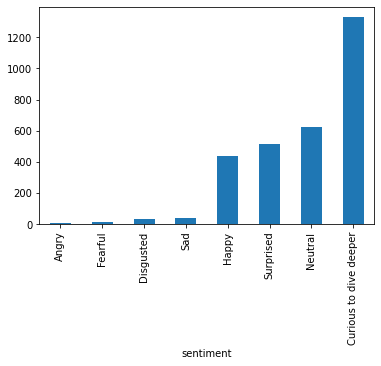

In [ ]:
batch.groupby('sentiment').count().sort_values('conversation_id')['conversation_id'].plot(kind='bar')

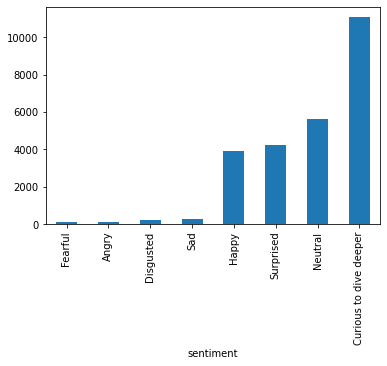

In [ ]:
pdChatData.groupby('sentiment').count().sort_values('conversation_id')['conversation_id'].plot(kind='bar')

In [ ]:
batch.head()
#5. encoding the outputs: target variables are also encoded to decimal values. 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
batch['Labels']=le.fit_transform(batch.sentiment)

In [ ]:
batch.head(2)

,conversation_id,config,agent,message,agent_1Overall,agent_2Overall,sentiment,turn_rating,knowledge_source,article_url,LemmatizedText,Labels
0,t_97fc26f7-f65d-448a-8821-3377fd99940b,D,agent_2,"You know the cat in The Godfather, well it was...",Not Good,Excellent,Curious to dive deeper,Excellent,FS3,https://www.washingtonpost.com/news/speaking-o...,know cat godfath well actual stray cat happen ...,1
1,t_bd119c16-ba56-4a66-8ba2-24ec76e59f2c,A,agent_1,"wow, interesting. did you ever watch that 70s ...",Excellent,Excellent,Curious to dive deeper,Good,FS1,https://www.washingtonpost.com/sports/capitals...,wow interest ever watch s show,1


In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
clear_output()

In [ ]:
model.parameters

<bound method Module.parameters of DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bi

In [ ]:
tokenized = batch['message'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized.shape

(3000,)

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = numpy.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = numpy.where(padded != 0, 1, 0)
numpy.array(padded).shape

(3000, 107)

In [ ]:
padded

array([[  101,  2017,  2113, ...,     0,     0,     0],
       [  101, 10166,  1010, ...,     0,     0,     0],
       [  101,  5399,  1010, ...,     0,     0,     0],
       ...,
       [  101,  7632,  2079, ...,     0,     0,     0],
       [  101,  2748,  2062, ...,     0,     0,     0],
       [  101,  1045,  2293, ...,     0,     0,     0]])

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)
attention_mask                                # what is attention mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
attention_mask.shape

torch.Size([3000, 107])

In [ ]:
# Getting Problem here 
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
last_hidden_states

BaseModelOutput([('last_hidden_state',
                  tensor([[[ 1.6567e-01, -6.6949e-02,  1.7985e-01,  ..., -1.7135e-01,
                             7.0161e-01,  2.0565e-01],
                           [ 2.5397e-01,  7.0899e-02,  1.6923e-01,  ...,  5.0216e-01,
                             1.2305e+00, -2.0669e-01],
                           [ 6.1853e-01,  2.6203e-01,  3.6307e-01,  ..., -1.6438e-01,
                             5.9033e-01,  1.4660e-01],
                           ...,
                           [ 3.9645e-01, -1.2161e-01,  2.7862e-01,  ..., -1.7596e-01,
                             1.0808e-01, -1.3232e-01],
                           [ 1.4681e-01, -3.8529e-01,  2.0982e-01,  ..., -1.4648e-01,
                             2.6288e-01, -2.9011e-01],
                           [ 1.1849e-01, -1.6061e-01,  1.9545e-01,  ..., -1.3928e-01,
                             2.5746e-01, -2.4221e-01]],
                  
                          [[ 7.8284e-02, -8.3663e-02, -3.3614e-

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = batch['Labels']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
train_features.shape

(2250, 768)

In [ ]:
test_features.shape

(750, 768)

In [ ]:
train_labels.shape

(2250,)

## Implementing Logistics regression

In [ ]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.464

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
pred = lr_clf.predict(test_features)
confusion_matrix(test_labels, pred)

array([[227,   0,   0,  28,  46,   0,  36],
       [  4,   0,   0,   0,   3,   0,   3],
       [  3,   0,   0,   0,   0,   0,   1],
       [ 54,   0,   0,  18,  23,   0,  15],
       [ 66,   0,   0,   9,  61,   1,  17],
       [  2,   0,   0,   1,   6,   1,   1],
       [ 65,   0,   0,   4,  14,   0,  41]])

In [ ]:
accuracy_score(test_labels, pred)

0.464

In [ ]:
train_labels

1572    7
2242    5
1995    1
1607    2
1625    4
       ..
319     5
557     7
560     4
845     1
1129    5
Name: Labels, Length: 2250, dtype: int64

In [ ]:
import xgboost as xgb
mlXgbr = xgb.XGBClassifier(n_estimators=100, eta=0.05,  subsample=0.25, colsample_bytree=0.5)
    
#we will try halving the number of samples and features respectively via the “subsample” and “colsample_bytree” hyperparameters.
mlXgbr.fit(train_features,train_labels)
y_pred_xgbr=mlXgbr.predict(test_features).round()
#calculate_mse_rmse_acc("XGBoost", y_test, y_pred_xgbr)
pdResult=DataFrame({"Actual":test_labels, "Predicted":y_pred_xgbr})
pdResult['Error']=pdResult.Predicted.round()-pdResult.Actual
accuracy_score(test_labels, y_pred_xgbr)

0.456

In [ ]:
#create list of model and accuracy dicts
perform_list = []

In [ ]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()       

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(train_features, train_labels)
    y_pred = oneVsRest.predict(test_features)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(test_labels, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(test_labels, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [ ]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 46.13
Precision : 0.4613333333333333
Recall    : 0.4613333333333333
F1-score   : 0.4613333333333333


In [ ]:
run_model('Linear SVC', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Linear SVC: % 43.33
Precision : 0.43333333333333335
Recall    : 0.43333333333333335
F1-score   : 0.43333333333333335


In [ ]:
model_performance = DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,46.13,0.46,0.46,0.46
1,Linear SVC,43.33,0.43,0.43,0.43
